In [1]:
!pwd
import sys
import os
path = os.getcwd()
path += '/../../'
sys.path.append(path)

import starburst
from starburst import utils
import log_jobs
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import time 
import copy 
from collections import OrderedDict 
import math
import heapq
import re
from IPython.display import display
import itertools
import pickle
pd.set_option('display.max_columns', None)

/home/gcpuser/starburst/starburst/plots


In [2]:
VMS = {
    '1705193847': 1705193847,
    '1705226483': 1705226483,
}
# TODO: Support both GPU and CPU (e.g. "workload_type")
logs =  "1705303043"#"1686798842"#"1684842093"#"1684842795"#"1686798842"# "1684842093"#"1686798842" #"1684842795" ##"1684842795" #"1684755479" #"1684754864" #"1684731034" #LOGS["1684630465"]

In [3]:
# TODO: Check for ground truth  -- Compare the datapoints from parse_job_df to ensure there are no missing jobs 

def parse_job_df(cluster_event_df=None, submission_df=None, sweep_df=None, avoid_congestion=True, columns=None, run_id=None, cloud_log_list=None):
    '''
    Parse onprem jobs first
    '''
    hyperparameters = None
    if 'hyperparameters' in submission_df: 
        hyperparameters = submission_df['hyperparameters']
    
    onprem_event_df = cluster_event_df['onprem']
    cloud_event_df = cluster_event_df['cloud']
    
    job_names = {}
    jobs = {}
    for col in columns: 
        jobs[col] = []

    all_nodes = set()
    nodes = {}
    node_counter = 0
    types = ['onprem', 'cloud']
    nodes_indices = {}
    intervals = {}
    
    print(cloud_log_list)
    
    for cluster_type in types: 
        event_df = cluster_event_df[cluster_type]
        try:
            job_times = {}
            pod_times = {}
            if cluster_type == 'cloud':
                for job in cloud_log_list[1:-1]:
                    match = re.search(r"Cloud Job \|\| job id (\S+) \| job name (\S+) \| estimated cloud start time (\S+) \| estimated job duration (\S+) \| submission time (\S+) \|", job)
                    if match:
                        match = match.groups()
                        job_id = int(match[0])
                        job_name = str(match[1])
                        submit = float(match[2])
                        duration = float(match[3])
                        arrival = float(match[4])
                        gpu = submission_df[str(job_id)]['workload']['gpu']
                        cpu = submission_df[str(job_id)]['workload']['cpu']
                        end = submit + 2 + duration 
                        
                        times = {"arrival": submission_df[str(job_id)]['scheduler_submit_time'],"submit": submit,"pod_start": submit + 2, "job_end": end, "gpu": gpu, "cpu":cpu}
                        print(f'matched time {times}')

                        missing = False
                        for v, k in times.items(): 
                            if not k: 
                                print(f'Missing {v} {k}')
                                missing = True
                        print(f'value {times}')
                    
                        pod_times[job_id] = times
                for job in cloud_log_list[1:-1]:
                    # Preempted Job || job id 18 | job name job-18 | estimated cloud start time 1705194017.1004813 | estimated job duration 702.0 | submission time 1705194012.3311865 | gpus 0 
                    match = re.search(r"Preempted Job \|\| job id (\S+) \| job name (\S+) \| estimated cloud start time (\S+) \| estimated job duration (\S+) \| submission time (\S+) \|", job)
                    if match:
                        match = match.groups()
                        job_id = int(match[0])
                        arrival = float(match[4])
                        if job_id in pod_times:
                            pod_times[job_id]['arrival'] = arrival
                intervals = pod_times
                nodes["cloud"] = node_counter
                #print(pod_times)
                print(f'Cloud Jobs {len(intervals)}')       
            else:   
                cluster = event_df
                start_times = cluster['container_start_times']
                creation_times = cluster['job_creation_times']
                completion_times = cluster['job_completion_times']
                # TODO: Verify node names works as intended
                pod_nodes = cluster['node_name']
                job_pods = cluster['job_pods']
                pod_jobs = {value: key for key, value in job_pods.items()}
                node_instances = cluster['node_instances']

                job_start_times = {}
                job_end_times = {}
                pod_start_times = {}

                for pod in start_times:
                    pod_name = pod
                    pod_start_time = start_times[pod]
                    pod_start_times[pod_name] = pod_start_time   

                for job in creation_times:
                    job_name = job
                    job_start_time = creation_times[job]
                    job_start_times[job_name] = job_start_time

                for job in completion_times:
                    job_name = job
                    job_end_time = completion_times[job]
                    job_end_times[job_name] = job_end_time
                       
                for pod in pod_nodes: 
                    all_nodes.add(pod_nodes[pod])

                for job in job_start_times:
                    if job in job_end_times:
                        job_times[job] = [job_start_times[job], job_end_times[job]]

                for pod in pod_start_times:
                    if pod in pod_jobs:
                        job = pod_jobs[pod]
                        if job not in job_end_times:
                            print("MISSING JOB " + str(job))
                        job_id = re.findall(r'\d+', job)[0]
                            
                        sub_time = submission_df[job_id]['scheduler_submit_time']
                        if job not in job_end_times: 
                            job_end_times[job] = sub_time + 100000
                            print("MISSING JOB " + str(job))
                            
                        pod_times[job] = [sub_time, job_end_times[job]]
                        #import pdb; pdb.set_trace()

                        times = {"arrival": submission_df[job_id]['scheduler_submit_time'], \
                                 # Submit is also job start time
                                 "submit": job_start_times[job], \
                                 "pod_start": pod_start_times[pod], \
                                 "job_end": job_end_times[job], \
                                }
                        print(f'matched time {times}')
                        missing = False
                        for v, k in times.items(): 
                            if not k: 
                                print(f'Missing {v} {k}')
                                missing = True
                                #continue
                        #if not missing:
                        print(f'value {times}')
                        if not times['job_end']:
                            times['job_end'] = times['submit'] + 1000000
                            
                        if job_id in {'87', '85'}: 
                            missing_runtime = times['job_end'] - times['pod_start']
                            print(f'MISSING RUNTIME {job_id} {missing_runtime}')
                        pod_times[job] = times
                        #else: 
                            #print("MISSING JOB " + str(job))

                # TODO: Possible cause of error 
                for n in all_nodes:
                    nodes[n] = node_counter
                    node_counter += 1

                intervals = pod_times
                print(f'Onprem Jobs {len(intervals)}')
                
        except Exception as e:
            import traceback
            print(f'matched time {times}')
            trace = traceback.format_exc()
            print(trace)

        gpu_indices = {}
        gpu_num = 0
        gpu_nums = {}
        gpu_node = {} #mapping from gpu_uuid to node_name
        node_gpus = {} #mapping from node_name to gpu_uuid to int [0, 7]
        print(f'interval {intervals}')
        for i, (key, value) in enumerate(intervals.items()):
            print(intervals)
            try:
                print(f'{cluster_type} value {value}')
                if cluster_type == 'cloud':
                    #print(key)
                    job_id = str(key)
                else:
                    job_id = re.findall(r'\d+', key)[0] #e.g. "sleep-26-100444"
                job_names[i] = key
                integer_id = job_id.split('-')[-1]
                jobs['idx'].append(int(integer_id))
                jobs['runtime'].append(value['job_end']-value['pod_start'])
                jobs['start'].append(value['pod_start'])
                jobs['arrival'].append(value['arrival'])
                jobs['submission_time'].append(value['submit'])
                #print(f'{cluster_type} value {value}')
                
                if cluster_type == 'cloud':
                    #print(value)
                    print(value)
                    jobs['num_gpus'].append(value['gpu'])
                    #TODO: Verify cpu value for cloud jobs
                    jobs['cpus'].append(value['cpu'])
                else:
                    jobs['num_gpus'].append(submission_df[job_id]['workload']['gpu'])
                    jobs['cpus'].append(submission_df[job_id]['workload']['cpu'])

                # TODO: Cleanup
                if avoid_congestion:
                    submit_time = cluster['job_creation_times'][key] #Job start time
                else:
                    submit_time = submission_df[job_id]['scheduler_submit_time'] #Job submission time
                
                if not submit_time:
                    jobs['wait_times'].append(0)
                else:
                    jobs['wait_times'].append(value['pod_start']-value['arrival'])

                if cluster_type == "cloud":
                    jobs['is_local'].append(0)
                else:
                    jobs['is_local'].append(1)
                
                #if cluster_type == 'cloud':
                
                if cluster_type == 'cloud':
                    jobs['instance_type'].append("unknown")
                    jobs['node'].append("cloud")
                    jobs['allocated_gpus'].append({})
                    jobs['node_index'].append(len(all_nodes) + 1)
                    jobs['allocated_gpus_real'].append({len(all_nodes): [i for i in range(value['gpu'])]})
                    #break
                    continue
                
                if job_pods[key] not in pod_nodes:
                    jobs['instance_type'].append("unknown")
                    jobs['allocated_gpus'].append({})
                    jobs['node_index'].append(None)
                    jobs['allocated_gpus_real'].append({1: []})
                    break
                
                if job_pods[key] in pod_nodes:
                    jobs['instance_type'].append(node_instances[pod_nodes[job_pods[key]]])
                else:
                    jobs['instance_type'].append("unknown")

                if job_pods[key] in pod_nodes:
                    jobs['allocated_gpus'].append({nodes[pod_nodes[job_pods[key]]]: []})
                    jobs['node_index'].append(nodes[pod_nodes[job_pods[key]]])
                else:
                    jobs['allocated_gpus'].append({})
                    jobs['node_index'].append(None)
                
                if job_pods[key] in pod_nodes:
                    jobs['node'].append(pod_nodes[job_pods[key]])
                else:
                    jobs['node'].append("unknown")
            
                if 'gpu_index' in cluster:
                    gpu_index = cluster['gpu_index'][job_pods[key]]
                    gpu_pod = job_pods[key]
                    gpu_index = gpu_index.partition("||")[0]
                    gpu_index = gpu_index.split("\n")
                    
                    for index in gpu_index:
                        if index != "":
                            gpu_node[index] = pod_nodes[gpu_pod]
                            if pod_nodes[gpu_pod] not in node_gpus:
                                node_gpus[pod_nodes[gpu_pod]] = {}
                            if index not in node_gpus[pod_nodes[gpu_pod]]:
                                node_gpus[pod_nodes[gpu_pod]][index] = len(node_gpus[pod_nodes[gpu_pod]])

                        if index != "" and index not in gpu_indices:
                            # TODO: Clean up later
                            gpu_indices[index] = gpu_num
                            gpu_num += 1
                    gpu_index = [node_gpus[pod_nodes[gpu_pod]][index] for index in gpu_index if index]
                    jobs['allocated_gpus_real'].append({nodes[pod_nodes[job_pods[key]]]: gpu_index})
                else:
                    jobs['allocated_gpus_real'].append({nodes[pod_nodes[job_pods[key]]]: []})
            except Exception as e:
                import traceback
                trace = traceback.format_exc()
                print(trace)
                if cluster_type == "cloud":
                    print('cloud')
                else:
                    print('onprem')
                
    if not jobs['arrival']:
        print("No job arrival times logged!")
    
    #print(f'nodes {nodes}')
    print(jobs)
    modified_arrival = [a for a in jobs['arrival'] if a]
    #min_arrival = min(modified_arrival)
    min_arrival = min(jobs['arrival'])
    #print(f'minarrival {min_arrival}')
    modified_submission = [s for s in jobs['submission_time'] if s]
    #min_submission = min(modified_submission)
    min_submission = min(jobs['submission_time'])
    #print(f'minsubmission {min_submission}')
    min_arrival = min_submission
    #min_arrival = min(jobs['submission_time'])
    jobs['arrival'] = [i - min_arrival for i in jobs['arrival']]
    jobs['submission_time'] = [i - min_arrival for i in jobs['submission_time']]
    jobs['start'] = [i - min_arrival for i in jobs['start']]
    #jobs['arrival'] = np.array(jobs['arrival'])
    jobs['num_gpus'] =  np.array(jobs['num_gpus'])
    
    hyperparameters = submission_df['hyperparameters']

    for k, v in hyperparameters.items():
        jobs[k] = v

    sweep_metrics = sweep_df[str(run_id)]
    jobs["varying_values"] = sweep_df["varying_values"].keys()
    jobs["fixed_values"] = sweep_df["fixed_values"].keys()

    for k, v in sweep_metrics.items():
        jobs[k + "_sweep"] = v
    
    with open("wait" + str(submission_df['hyperparameters']['wait_time']) + "uni" + str(submission_df['hyperparameters']['uniform_arrival']) + ".pkl", 'wb') as file:
        pickle.dump(jobs, file)

    return jobs, len(all_nodes), hyperparameters

def parse_jobs_df(event_number=logs, avoid_congestion=False):
    #TODO: Move log_jobs from local to remote repo
    events_dfs, submission_df, sweep_df = log_jobs.retrieve_events_df(event_number=logs, avoid_congestion=False, only_dict=False)
    columns=['idx', 'runtime', 'arrival', 'num_gpus', 'allocated_gpus', 'allocated_gpus_real', 'start', 'instance_type', 'node_index', 'node', 'cpus', 'submission_time', 'wait_times', 'is_local']
    runs = {}
    run_id = 0
    cluster_event_df = events_dfs
    display(submission_df)
    estimated_runtimes = []
    for job in submission_df:
        if job == 'hyperparameters':
            continue
        #estimated_runtimes.append((job, submission_df[job]["job_duration"]))
        estimated_runtimes.append(submission_df[job]["job_duration"])
        #print(job)
        #print(submission_df[job]["job_duration"])
    print(estimated_runtimes)
    onprem_df, cloud_df = cluster_event_df
    with open(f'../logs/archive/{logs}/events/{0}.log', "r") as f:
        cloud_log_list = f.read().split('\n')
    try:
        run, _, _ = parse_job_df(cluster_event_df=cluster_event_df, submission_df=submission_df, sweep_df=sweep_df, avoid_congestion=False, columns=columns, run_id=run_id, cloud_log_list=cloud_log_list)
        runs[run_id] = pd.Series(run)
    except Exception as e:
        import traceback
        trace = traceback.format_exc()
        print(trace)
    runs_df = pd.DataFrame.from_dict(runs)
    runs_df = runs_df.transpose()
    return runs_df

jobs_df = parse_jobs_df(event_number=logs, avoid_congestion=False)
#jobs_df = jobs_df[0:2]
display(jobs_df)

[Errno 2] No such file or directory: '../logs/archive/1705303043/events/1.json'


,hyperparameters,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114
job_type,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train
image,gcr.io/sky-burst/skyburst:latest,gcr.io/sky-burst/skyburst:latest,gcr.io/sky-burst/skyburst:latest,gcr.io/sky-burst/skyburst:latest,gcr.io/sky-burst/skyburst:latest,gcr.io/sky-burst/skyburst:latest,gcr.io/sky-burst/skyburst:latest,gcr.io/sky-burst/skyburst:latest,gcr.io/sky-burst/skyburst:latest,gcr.io/sky-burst/skyburst:latest,gcr.io/sky-burst/skyburst:latest,gcr.io/sky-burst/skyburst:latest,gcr.io/sky-burst/skyburst:latest,gcr.io/sky-burst/skyburst:latest,gcr.io/sky-burst/skyburst:latest,gcr.io/sky-burst/skyburst:latest,gcr.io/sky-burst/skyburst:latest,gcr.io/sky-burst/skyburst:latest,gcr.io/sky-burst/skyburst:latest,gcr.io/sky-burst/skyburst:latest,gcr.io/sky-burst/skyburst:latest,gcr.io/sky-burst/skyburst:latest,gcr.io/sky-burst/skyburst:latest,gcr.io/sky-burst/skyburst:latest,gcr.io/sky-burst/skyburst:latest,gcr.io/sky-burst/skyburst:latest,gcr.io/sky-burst/skyburst:latest,gcr.io/sky-burst/skyburst:latest,gcr.io/sky-burst/skyburst:latest,gcr.io/sky-burst/skyburst:latest,gcr.io/sky-burst/skyburst:latest,gcr.io/sky-burst/skyburst:latest,gcr.io/sky-burst/skyburst:latest,gcr.io/sky-burst/skyburst:latest,gcr.io/sky-burst/skyburst:latest,gcr.io/sky-burst/skyburst:latest,gcr.io/sky-burst/skyburst:latest,gcr.io/sky-burst/skyburst:latest,gcr.io/sky-burst/skyburst:latest,gcr.io/sky-burst/skyburst:latest,gcr.io/sky-burst/skyburst:latest,gcr.io/sky-burst/skyburst:latest,gcr.io/sky-burst/skyburst:latest,gcr.io/sky-burst/skyburst:latest,gcr.io/sky-burst/skyburst:latest,gcr.io/sky-burst/skyburst:latest,gcr.io/sky-burst/skyburst:latest,gcr.io/sky-burst/skyburst:latest,gcr.io/sky-burst/skyburst:latest,gcr.io/sky-burst/skyburst:latest,gcr.io/sky-burst/skyburst:latest,gcr.io/sky-burst/skyburst:latest,gcr.io/sky-burst/skyburst:latest,gcr.io/sky-burst/skyburst:latest,gcr.io/sky-burst/skyburst:latest,gcr.io/sky-burst/skyburst:latest,gcr.io/sky-burst/skyburst:latest,gcr.io/sky-burst/skyburst:latest,gcr.io/sky-burst/skyburst:latest,gcr.io/sky-burst/skyburst:latest,gcr.io/sky-burst/skyburst:latest,gcr.io/sky-burst/skyburst:latest,gcr.io/sky-burst/skyburst:latest,gcr.io/sky-burst/skyburst:latest,gcr.io/sky-burst/skyburst:latest,gcr.io/sky-burst/skyburst:latest,gcr.io/sky-burst/skyburst:latest,gcr.io/sky-burst/skyburst:latest,gcr.io/sky-burst/skyburst:latest,gcr.io/sky-burst/skyburst:latest,gcr.io/sky-burst/skyburst:latest,gcr.io/sky-burst/skyburst:latest,gcr.io/sky-burst/skyburst:latest,gcr.io/sky-burst/skyburst:latest,gcr.io/sky-burst/skyburst:latest,gcr.io/sky-burst/skyburst:latest,gcr.io/sky-burst/skyburst:latest,gcr.io/sky-burst/skyburst:latest,gcr.io/sky-burst/skyburst:latest,gcr.io/sky-burst/skyburst:latest,gcr.io/sky-burst/skyburst:latest,gcr.io/sky-burst/skyburst:latest,gcr.io/sky-burst/skyburst:latest,gcr.io/sky-burst/skyburst:latest,gcr.io/sky-burst/skyburst:latest,gcr.io/sky-burst/skyburst:latest,gcr.io/sky-burst/skyburst:latest,gcr.io/sky-burst/skyburst:latest,gcr.io/sky-burst/s

[1696, 1840, 2794, 848, 1270, 1143, 8046, 6750, 2682, 4821, 1696, 8400, 3360, 3200, 1216, 2533, 1696, 298, 7020, 2286, 4950, 596, 9983, 304, 608, 608, 8640, 3874, 1524, 447, 212, 596, 2831, 8892, 5066, 450, 3744, 702, 800, 702, 2106, 4768, 424, 848, 2235, 1696, 234, 114, 889, 381, 2340, 894, 381, 1341, 6477, 212, 6523, 9983, 1120, 2980, 7366, 1341, 480, 635, 254, 4821, 6786, 1200, 640, 1696, 640, 1840, 480, 8640, 608, 848, 848, 1800, 1696, 3200, 4768, 2794, 56, 894, 1200, 4821, 1524, 7760, 2250, 848, 1696, 1840, 127, 56, 640, 702, 750, 635, 1872, 450, 1216, 889, 89, 2682, 8522, 6880, 848, 1638, 1696, 1651, 66, 1651, 635, 160, 212]
['Scheduler spun up! ', 'Preempted Job || job id 16 | job name job-16 | estimated cloud start time 1705304301.5997276 | estimated job duration 1696 | submission time 1705304286.5716214 | gpus 0 ', 'Cloud Job || job id 17 | job name job-17 | estimated cloud start time 1705304318.6328192 | estimated job duration 298 | submission time 1705304303.6035883 | gpus 0

,idx,runtime,arrival,num_gpus,allocated_gpus,allocated_gpus_real,start,instance_type,node_index,node,cpus,submission_time,wait_times,is_local,job_type,image,setup_script,uniform_arrival,uniform_submission,waiting_policy,policy,time_constrained,cluster_size,cpus_per_node,gpus_per_node,cloud_cluster_nodes,cloud_cpu_per_node,random_seed,total_jobs,batch_time,wait_time,time_out,mean_duration,arrival_rate,cpu_sizes,cpu_dist,gpu_sizes,gpu_dist,memory_sizes,memory_dict,train_names,train_dist,use_new_cluster,onprem_cluster,cloud_cluster,gpu_workload,spill_to_cloud,onprem_only,collect_runtimes,sample_real_workloads,sched_tick,workload,job_duration,submit_time,scheduler_submit_time,varying_values,fixed_values,batch_time_sweep,mean_duration_sweep,waiting_policy_sweep,cpu_dist_sweep,cpu_sizes_sweep,gpu_dist_sweep,gpu_sizes_sweep,uniform_submission_sweep,uniform_arrival_sweep,onprem_cluster_sweep,cloud_cluster_sweep,cluster_size_sweep,gpu_workload_sweep,gpus_per_node_sweep,sched_tick_sweep,wait_time_sweep,random_seed_sweep,spill_to_cloud_sweep,arrival_rate_sweep,sample_real_workloads_sweep,job_type_sweep,image_sweep,policy_sweep,setup_script_sweep,time_constrained_sweep,cpus_per_node_sweep,cloud_cluster_nodes_sweep,cloud_cpu_per_node_sweep,total_jobs_sweep,time_out_sweep,memory_sizes_sweep,memory_dict_sweep,train_names_sweep,train_dist_sweep,use_new_cluster_sweep,onprem_only_sweep,collect_runtimes_sweep
0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[1699, 1844, 2797, 852, 1273, 1146, 8049, 6753...","[-1.0699834823608398, 403.6239404678345, 571.6...","[2, 8, 1, 2, 1, 1, 1, 1, 1, 4, 2, 1, 1, 1, 4, ...","[{3: []}, {1: []}, {3: []}, {3: []}, {3: []}, ...","[{3: []}, {1: []}, {3: []}, {3: []}, {3: []}, ...","[1, 406, 574, 578, 797, 830, 880, 923, 931, 93...","[n2-standard-96, n2-standard-96, n2-standard-9...","[3, 1, 3, 3, 3, 3, 3, 0, 0, 0, 0, 2, 2, 2, 2, ...","[gke-mluo-onprem-starburst-cpu-e85c4cfe-296f, ...","[22, 88, 11, 22, 11, 11, 11, 11, 11, 44, 22, 1...","[0, 405, 573, 577, 796, 829, 879, 922, 930, 93...","[2.06998348236084, 2.3760595321655273, 2.30360...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",train,gcr.io/sky-burst/skyburst:latest,"nvidia-smi --query-gpu=index --format=csv,nohe...",10,False,fifo_wait,star-wait,True,4,8,8,4,8,13,125,10800,15,5,2700,0.008889,"[11, 22, 44, 88]","[0.25, 0.25, 0.25, 0.25]","[1, 2, 4, 8]","[0.7, 0.15, 0.1, 0.05]","[100, 500, 1000, 50000]","[0.25, 0.25, 0.25, 0.25]",[test],[1],True,mluo-onprem,mluo-cloud,True,False,False,False,True,0.1,NaN,NaN,NaN,NaN,"Index(['batch_time', 'mean_duration', 'waiting...","Index(['batch_time', 'mean_duration', 'waiting...",10800,2700,fifo_wait,"[0.25, 0.25, 0.25, 0.25]","[11, 22, 44, 88]","[0.7, 0.15, 0.1, 0.05]","[1, 2, 4, 8]",False,10,mluo-onprem,mluo-cloud,4,True,8,0.1,15,13,False,0.008889,True,train,gcr.io/sky-burst/skyburst:latest,star-wait,"nvidia-smi --query-gpu=index --format=csv,nohe...",True,8,4,8,125,5,"[100, 500, 1000, 50000]","[0.25, 0.25, 0.25, 0.25]",[test],[1],True,False,False


In [16]:
if 'workload_type' in jobs_df: 
    print(jobs_df['workload_type'][0])
jobs_df['arrival'][0]
# print(len(jobs_df['runtime'][0]))
# print(len(jobs_df['is_local'][0]))
# print(sum(jobs_df['is_local'][0]))
# print(len(jobs_df['arrival'][0]))
# print(len(jobs_df['start'][0]))
# print(len(jobs_df['submission_time'][0]))
# print(len(jobs_df['runtime'][0]))
# print(len(jobs_df['node'][0]))
# print(len(jobs_df['node_index'][0]))
# print(len(jobs_df['instance_type'][0]))
# print(len(jobs_df['allocated_gpus'][0]))
# print(len(jobs_df['allocated_gpus_real'][0]))

# print(sorted(jobs_df['runtime'][0]))
# print(jobs_df['is_local'][0])
# print(jobs_df['arrival'][0])
# print(jobs_df['start'][0])
# print(jobs_df['submission_time'])
# print(jobs_df['runtime'])
# print(jobs_df['node_index'])
# print(jobs_df['node'][0])
# print(jobs_df['instance_type'][0])
# print(jobs_df['allocated_gpus'][0])
# print(jobs_df['allocated_gpus_real'][0])

[-1.7431185245513916,
 526.8388671875,
 746.3587732315063,
 751.5934102535248,
 1037.4414355754852,
 1080.9510164260864,
 1146.1453611850739,
 1202.683834552765,
 1212.5625278949738,
 1215.570255279541,
 1227.1449060440063,
 1323.1932592391968,
 1364.8781180381775,
 1412.5308315753937,
 1453.7254054546356,
 1523.8114929199219,
 1620.026288986206,
 1631.1280372142792,
 1837.040682554245,
 1580.1537146568298,
 1654.1122379302979,
 2005.7067987918854,
 1534.1492283344269,
 2148.939090013504,
 2169.0929334163666,
 2198.02986741066,
 2026.8627874851227,
 1938.6089415550232,
 2699.873496055603,
 3361.374890089035,
 3407.4954884052277,
 3582.8129522800446,
 3621.912000656128,
 3793.483952522278,
 3803.7658853530884,
 3823.2620322704315,
 3828.320405483246,
 4037.9732110500336,
 4395.5235052108765,
 4398.519230127335,
 4410.726608276367,
 4532.764524459839,
 4548.00078868866,
 4990.7779994010925,
 5199.54128074646,
 5386.966507196426,
 5412.817546129227,
 5466.211352825165,
 5474.19265460968,


In [4]:
#jobs_df['arrival_mask'] = jobs_df['start'].apply(lambda x: [0 if not i else 1 for i in x])
jobs_df['arrival_mask'] = jobs_df['is_local']#.apply(lambda x: [0 if not i else 1 for i in x])
jobs_df['onprem_mask'] = jobs_df['arrival_mask']

# CLIP WAITS

def cloud_wait_unclipped(row): 
    cloud_wait = [row['wait_times'][i] for i, n in enumerate(row['arrival_mask']) if n == 0]
    return cloud_wait
jobs_df['cloud_wait_unclipped'] = jobs_df.apply(cloud_wait_unclipped, axis=1)

def clipped_wait(row): 
    k8s_scheduling_waiting_constant = 1 #wait_time_2
    onprem_wait = [row['wait_times'][i] for i, n in enumerate(row['arrival_mask']) if n == 1]
    cloud_wait = [k8s_scheduling_waiting_constant + row['wait_time'] for i, n in enumerate(row['arrival_mask']) if n == 0]
    new_wait = onprem_wait + cloud_wait
    return new_wait

jobs_df['wait_times'] = jobs_df.apply(clipped_wait, axis=1)

def cloud_wait(row): 
    k8s_scheduling_waiting_constant = 1 #wait_time_2
    cloud_wait = [k8s_scheduling_waiting_constant + row['wait_time'] for i, n in enumerate(row['arrival_mask']) if n == 0]
    return cloud_wait
jobs_df['cloud_wait'] = jobs_df.apply(cloud_wait, axis=1)


def onprem_wait(row): 
    k8s_scheduling_waiting_constant = 1 #wait_time_2
    onprem_wait = [row['wait_times'][i] for i, n in enumerate(row['arrival_mask']) if n == 1]
    return onprem_wait

jobs_df['onprem_wait'] = jobs_df.apply(onprem_wait, axis=1)

# COMPUTE METRICS

jobs_df['avg_wait'] = jobs_df['wait_times'].apply(lambda x: sum(x)/len(x))
jobs_df['avg_runtime'] = jobs_df['runtime'].apply(lambda x: sum(x)/len(x))

def compute_total_time(row):
    total_time = [row['wait_times'][i] + row['runtime'][i] for i in range(len(row['wait_times']))]
    return total_time


jobs_df['total_time'] = jobs_df.apply(compute_total_time, axis=1)

def compute_completion_time(row):
    # TODO: Submission time is time submitted to starburst 
    #completion_time = [row['total_time'][i] + row['submission_time'][i] for i in range(len(row['wait_times']))]
    completion_time = [row['total_time'][i] + row['arrival'][i] for i in range(len(row['wait_times']))]
    return completion_time

jobs_df['completion_time'] = jobs_df.apply(compute_completion_time, axis=1)
#jobs_df['avg_jct'] = jobs_df['total_time'].apply(lambda x: sum(x)/len(x))

def compute_avg_jct(row):
    arrival_times = row['arrival']
    run_time = row['runtime']
    wait_time = row['wait_times']
    resources = row['num_gpus']
    starts = row['start']
    idxes = row['idx']
    is_locals = row['is_local']
    sort_zip = sorted(zip(idxes, arrival_times, run_time, starts, resources, wait_time))
    
    #start = sort_zip[10][1]
    #end = sort_zip[-10][1]
    
    total_used_space = 0
    total_time = 0
    
    for l in sort_zip:
        #job_idx = l[0]
        #job_arrival = l[1]
        job_runtime = l[2]
        job_wait_time = l[1]
        #job_start = l[3]
        job_gpus = l[4]
        wait_time = l[5]
        #inter_start = max(job_start, start)
        #inter_end = min(job_start + job_runtime, end)
        #if inter_end >= inter_start:
        #    total_used_space+= job_gpus * (inter_end - inter_start)
        total_time += job_runtime
        total_time += wait_time
        
    jct = total_time/len(sort_zip)#total_used_space/(row['cluster_size']*4*row['gpus_per_node']*(end-start))
    jct = jct/3600
    return jct
jobs_df['avg_jct'] = jobs_df.apply(compute_avg_jct, axis=1)

def compute_cluster_utilization(row):
    arrival_times = row['arrival']
    run_time = row['runtime']
    resources = row['num_gpus']
    starts = row['start']
    idxes = row['idx']
    is_locals = row['is_local']
    sort_zip = sorted(zip(idxes, arrival_times, run_time, starts, resources, is_locals))
    
    start = sort_zip[0][1]
    end = sort_zip[-1][1]
    total_used_space = 0
    for l in sort_zip:
        job_idx = l[0]
        job_arrival = l[1]
        job_runtime = l[2]
        job_start = l[3]
        job_gpus = l[4]
        is_local = l[5]
        print(is_local)
        if is_local==1:
            inter_start = max(job_start, start)
            inter_end = min(job_start + job_runtime, end)
            #import pdb; pdb.set_trace()
            if inter_end >= inter_start:
                total_used_space+= job_gpus * (inter_end - inter_start)
    cluster_utilization = total_used_space/(row['cluster_size']*row['gpus_per_node']*(end-start))
    print(cluster_utilization)
    return cluster_utilization
        
#     # TODO: Remove previous arrival and 
#     print(row['arrival'])
#     surface_area = [row['runtime'][i] * row['num_gpus'][i] for i in range(len(row['runtime']))]
#     utilized_surface_area = sum(surface_area)
#     total_surface_area = (max(row['completion_time']) - min(row['submission_time'])) * (row['gpus_per_node'] * 1) #row['cluster_size'])
#     cluster_utilization = utilized_surface_area/total_surface_area
#     return cluster_utilization

jobs_df['cluster_utilization'] = jobs_df.apply(compute_cluster_utilization, axis=1)

def compute_system_utilization(row):
    arrival_times = row['arrival']
    run_time = row['runtime']
    resources = row['num_gpus']
    starts = row['start']
    idxes = row['idx']
    is_locals = row['is_local']
    sort_zip = sorted(zip(idxes, arrival_times, run_time, starts, resources, is_locals))
    
    start = sort_zip[0][1]
    end = sort_zip[-1][1]
    
    total_used_space = 0
    for l in sort_zip:
        job_idx = l[0]
        job_arrival = l[1]
        job_runtime = l[2]
        job_start = l[3]
        job_gpus = l[4]
        is_local = l[5]
        inter_start = max(job_start, start)
        inter_end = min(job_start + job_runtime, end)
        if inter_end >= inter_start:
            total_used_space += job_gpus * (inter_end - inter_start)
    system_utilization = total_used_space/(row['cluster_size']*4*row['gpus_per_node']*(end-start))
    
    return system_utilization

jobs_df['system_utilization'] = jobs_df.apply(compute_system_utilization, axis=1)

        
#     # TODO: Remove previous arrival and 
#     print(row['arrival'])
#     surface_area = [row['runtime'][i] * row['num_gpus'][i] for i in range(len(row['runtime']))]
#     utilized_surface_area = sum(surface_area)
#     total_surface_area = (max(row['completion_time']) - min(row['submission_time'])) * (row['gpus_per_node'] * 1) #row['cluster_size'])
#     cluster_utilization = utilized_surface_area/total_surface_area
#     return cluster_utilization


#def compute_system_utilization(row):
    # TODO: Compute this value correctly
    #return system_utilization

#jobs_df['cluster_utilization'] = jobs_df.apply(compute_cluster_utilization, axis=1)
GCP_PRICES = {
    "e2-medium": 0.038795,
    "e2-standard-8": 0.31036,
    "unknown": 0.038795,
    "n1-standard-96": 4.56 
}

def compute_total_cost(row):
    run_time = row['runtime']
    resources = row['num_gpus']
    idxes = row['idx']
    is_locals = row['is_local']
    sort_zip = sorted(zip(idxes, run_time, resources, is_locals))

    
    total_cloud_cost = 0
    for l in sort_zip:
        job_idx = l[0]
        job_runtime = l[1]
        job_gpus = l[2]
        is_local = l[3]
        if is_local==0:
            print(job_gpus, job_runtime)
            total_cloud_cost += job_runtime * job_gpus
    print(total_cloud_cost/360)
    return total_cloud_cost/3600
    # TODO: Compute this value correctly
    # Get all cloud runtimes + submit 
#     total_time = [row['runtime'][i] * row['num_gpus'][i] * (1 - row['arrival_mask'][i]) * GCP_PRICES[row['instance_type'][i]] for i in range(len(row['arrival_mask']))]
#     return sum(total_time)

jobs_df['total_cloud_cost'] = jobs_df.apply(compute_total_cost, axis=1)

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
0
1
0.8464311757585942
1 298.0
4 56.0
2 66.0
1 160.0
2.261111111111111


In [5]:
jobs_df

,idx,runtime,arrival,num_gpus,allocated_gpus,allocated_gpus_real,start,instance_type,node_index,node,cpus,submission_time,wait_times,is_local,job_type,image,setup_script,uniform_arrival,uniform_submission,waiting_policy,policy,time_constrained,cluster_size,cpus_per_node,gpus_per_node,cloud_cluster_nodes,cloud_cpu_per_node,random_seed,total_jobs,batch_time,wait_time,time_out,mean_duration,arrival_rate,cpu_sizes,cpu_dist,gpu_sizes,gpu_dist,memory_sizes,memory_dict,train_names,train_dist,use_new_cluster,onprem_cluster,cloud_cluster,gpu_workload,spill_to_cloud,onprem_only,collect_runtimes,sample_real_workloads,sched_tick,workload,job_duration,submit_time,scheduler_submit_time,varying_values,fixed_values,batch_time_sweep,mean_duration_sweep,waiting_policy_sweep,cpu_dist_sweep,cpu_sizes_sweep,gpu_dist_sweep,gpu_sizes_sweep,uniform_submission_sweep,uniform_arrival_sweep,onprem_cluster_sweep,cloud_cluster_sweep,cluster_size_sweep,gpu_workload_sweep,gpus_per_node_sweep,sched_tick_sweep,wait_time_sweep,random_seed_sweep,spill_to_cloud_sweep,arrival_rate_sweep,sample_real_workloads_sweep,job_type_sweep,image_sweep,policy_sweep,setup_script_sweep,time_constrained_sweep,cpus_per_node_sweep,cloud_cluster_nodes_sweep,cloud_cpu_per_node_sweep,total_jobs_sweep,time_out_sweep,memory_sizes_sweep,memory_dict_sweep,train_names_sweep,train_dist_sweep,use_new_cluster_sweep,onprem_only_sweep,collect_runtimes_sweep,arrival_mask,onprem_mask,cloud_wait_unclipped,cloud_wait,onprem_wait,avg_wait,avg_runtime,total_time,completion_time,avg_jct,cluster_utilization,system_utilization,total_cloud_cost
0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[1699, 1844, 2797, 852, 1273, 1146, 8049, 6753...","[-1.0699834823608398, 403.6239404678345, 571.6...","[2, 8, 1, 2, 1, 1, 1, 1, 1, 4, 2, 1, 1, 1, 4, ...","[{3: []}, {1: []}, {3: []}, {3: []}, {3: []}, ...","[{3: []}, {1: []}, {3: []}, {3: []}, {3: []}, ...","[1, 406, 574, 578, 797, 830, 880, 923, 931, 93...","[n2-standard-96, n2-standard-96, n2-standard-9...","[3, 1, 3, 3, 3, 3, 3, 0, 0, 0, 0, 2, 2, 2, 2, ...","[gke-mluo-onprem-starburst-cpu-e85c4cfe-296f, ...","[22, 88, 11, 22, 11, 11, 11, 11, 11, 44, 22, 1...","[0, 405, 573, 577, 796, 829, 879, 922, 930, 93...","[2.06998348236084, 2.3760595321655273, 2.30360...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",train,gcr.io/sky-burst/skyburst:latest,"nvidia-smi --query-gpu=index --format=csv,nohe...",10,False,fifo_wait,star-wait,True,4,8,8,4,8,13,125,10800,15,5,2700,0.008889,"[11, 22, 44, 88]","[0.25, 0.25, 0.25, 0.25]","[1, 2, 4, 8]","[0.7, 0.15, 0.1, 0.05]","[100, 500, 1000, 50000]","[0.25, 0.25, 0.25, 0.25]",[test],[1],True,mluo-onprem,mluo-cloud,True,False,False,False,True,0.1,NaN,NaN,NaN,NaN,"Index(['batch_time', 'mean_duration', 'waiting...","Index(['batch_time', 'mean_duration', 'waiting...",10800,2700,fifo_wait,"[0.25, 0.25, 0.25, 0.25]","[11, 22, 44, 88]","[0.7, 0.15, 0.1, 0.05]","[1, 2, 4, 8]",False,10,mluo-onprem,mluo-cloud,4,True,8,0.1,15,13,False,0.008889,True,train,gcr.io/sky-burst/skyburst:latest,star-wait,"nvidia-smi --query-gpu=index --format=csv,nohe...",True,8,4,8,125,5,"[100, 500, 1000, 50000]","[0.25, 0.25, 0.25, 0.25]",[test],[1],True,False,False,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[17.385010719299316, 17.90631937980652, 17.896...","[16, 16, 16, 16]","[2.06998348236084, 2.3760595321655273, 2.30360...",171.215858,4033.435656,"[1701.0699834823608, 1846.3760595321655, 2799....","[1700.0, 2250.0, 3371.0, 1430.0, 2070.0, 1976....",1.167959,0.846431,0.212136,0.226111


: 

[(0, 1), (1, 529), (2, 748), (3, 753), (4, 1040), (5, 1083), (6, 1148), (7, 1205), (8, 1215), (9, 1218), (10, 1229), (11, 1325), (12, 1368), (13, 1415), (14, 1456), (15, 1526), (16, 1622), (17, 1633), (18, 1840), (19, 1896), (20, 2231), (21, 2373), (22, 2375), (23, 2465), (24, 2485), (25, 2514), (26, 2677), (27, 2986), (28, 3016), (29, 3363), (30, 3409), (31, 3585), (32, 3624), (33, 3796), (34, 3806), (35, 3825), (36, 3830), (37, 4041), (38, 4398), (39, 4400), (40, 4413), (41, 4535), (42, 4551), (43, 4993), (44, 5202), (45, 5389), (46, 5416), (47, 5469), (48, 5477), (49, 5581), (50, 5684), (51, 5957), (52, 6195), (53, 6379), (54, 6505), (55, 6508), (56, 6682), (57, 6703), (58, 6844), (59, 6862), (60, 7289), (61, 7336), (62, 7569), (63, 7833), (64, 7860), (65, 7954), (66, 8460), (67, 8770), (68, 9002), (69, 9111), (70, 9303), (71, 9500), (72, 9552), (73, 9722), (74, 9738), (75, 9796), (76, 9852), (77, 10153), (78, 10157), (79, 10437), (80, 10466), (81, 10478), (82, 10498), (83, 10508), 

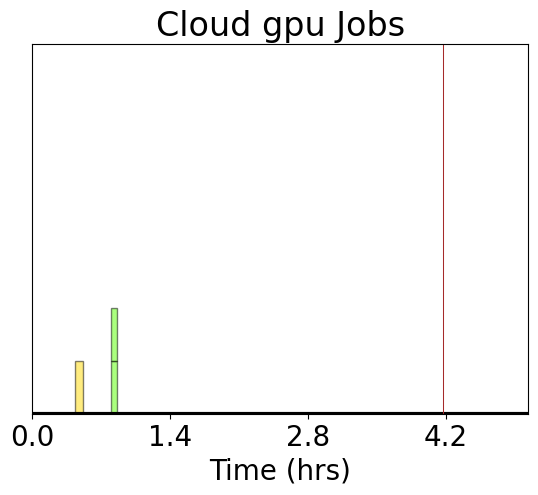

gpus
[2 8 1 2 1 1 1 1 1 4 2 1 1 1 4 1 1 1 1 1 1 4 2 1 1 1 4 4 1 1 1 1 1 1 1 1 1
 1 1 1 2 2 1 2 1 1 1 1 1 1 1 1 1 2 4 1 1 1 1 1 1 1 1 4 1 1 1 2 1 1 1 4 2 2
 1 2 1 1 1 4 1 1 4 1 8 1 8 1 2]
cpus list
[22, 88, 11, 22, 11, 11, 11, 11, 11, 44, 22, 11, 11, 11, 44, 11, 11, 11, 11, 11, 11, 44, 22, 11, 11, 11, 44, 44, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 22, 22, 11, 22, 11, 11, 11, 11, 11, 11, 11, 11, 11, 22, 44, 11, 11, 11, 11, 11, 11, 11, 11, 44, 11, 11, 11, 22, 11, 11, 11, 44, 22, 22, 11, 22, 11, 11, 11, 44, 11, 11, 44, 11, 88, 11, 88, 11, 22]
job_cpu_size 2
allocated resources -- cpus or gpus: [1, 2]
job_cpu_size 8
allocated resources -- cpus or gpus: [1, 2, 3, 4, 5, 6, 7, 8]
job_cpu_size 1
allocated resources -- cpus or gpus: [3]
job_cpu_size 2
allocated resources -- cpus or gpus: [4, 5]
job_cpu_size 1
allocated resources -- cpus or gpus: [6]
job_cpu_size 1
allocated resources -- cpus or gpus: [7]
job_cpu_size 1
allocated resources -- cpus or gpus: [8]
job_cpu_size 1
allocated re

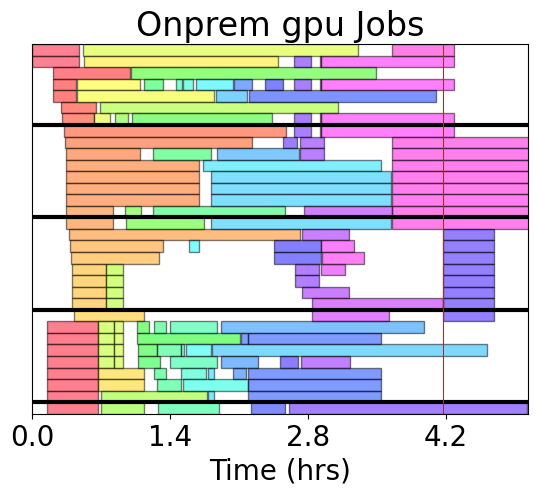

0    None
dtype: object

In [20]:
def index_mapping(jobs=None, gpus_per_node=8, resource='cpu'):#gpu_value=None):
    '''
    Implement greedly algorithm with heap to place jobs to free resource indicies
    
    Specify which resource (e.g. gpu, cpu) to use fitting jobs to indices
    
    (1) Add all jobs to queue, then greedily assign indicies 
    (2) Have priority queue for each node with "Free indices" sorted by index number 
    (3) Iterate over all start times 

    TODO: Fix 1-off CPU index error 
    TODO: Don't let any job_idx values to be -1, and ensure it starts at node 1
    TODO: Verify allocated_nodes
    TODO: Determine how parsing changes between http_info and default values 
    TODO: Verify arrival value is accurate
    TODO: Create a list of times that include all arrival times and completion times in the same list in numerical order 
    '''
    '''
    if gpu_jobs: 
        gpu_value = 'allocated_gpus_index'
    else: 
        gpu_value = 'allocated_gpus'
    '''
    workload = 'gpu'
    if 'workload_type' in jobs: 
        print('workload type')
        print(jobs['workload_type'])
        workload = jobs['workload_type']
    print('gpus')
    print(jobs['num_gpus'])
    print('cpus list')
    print(jobs['cpus'])
    #import pdb; pdb.set_trace()
    GPUS_PER_NODE = gpus_per_node
    allocated_nodes = jobs['node_index']
    
    
    #if resource == 'gpu':
    if workload == 'gpu':
        cpus = jobs['num_gpus']
    else: 
        cpus = jobs['cpus']
    #gpus = jobs['gpus']
    nodes = set(allocated_nodes)
    
    node_jobs ={}
    node_queues = {}
    for node in nodes:
        node_queues[node] = [i + 1 for i in range(GPUS_PER_NODE)]
        node_jobs[node] = []

    global_queue = [] # Queue sorted on end time -- earliest to latest end time
    job_id_to_index = {} 

    for i in range(len(jobs['arrival'])):
        #Remove values from queue
        #import pdb; pdb.set_trace()
        job_id = jobs['idx'][i]
        job_id_to_index[job_id] = i
        job_node = jobs['node_index'][i]
        #if resource == 'gpu':
        if workload == 'gpu':
            job_cpu_size = jobs['num_gpus'][i]
        else: 
            job_cpu_size = jobs['cpus'][i]
        job_arrival = jobs['arrival_plot'][i]
        job_runtime = jobs['runtime'][i]
        
        while global_queue and global_queue[0][0] <= job_arrival: 
            end_time, end_job_id = heapq.heappop(global_queue)
            released_index = job_id_to_index[end_job_id]
            for released_node in jobs['allocated_gpus'][released_index]: 
                released_cpus = jobs['allocated_gpus'][released_index][released_node]
                released_node_queue = node_queues[released_node]
                try:
                    node_jobs[released_node].remove(end_job_id)
                except:
                    #import pdb; pdb.set_trace()
                    print("Job Id not found")
                    print(end_job_id)
                    print(node_jobs[released_node])
                    continue
                for cpu in released_cpus:
                    heapq.heappush(released_node_queue, cpu)

        heapq.heappush(global_queue, (job_arrival + job_runtime, job_id))
        job_allocated_cpus = []
        node_queue = node_queues[job_node]
        node_jobs[job_node].append(job_id)
    
        print(f'job_cpu_size {job_cpu_size}')
        try:
            for j in range(job_cpu_size):
                cpu_index = heapq.heappop(node_queue)
                job_allocated_cpus.append(cpu_index)
        except:
            print("not enough cpus to fit jobs")
            print(node_queue)
            print(job_allocated_cpus)
        
        print(f'allocated resources -- cpus or gpus: {job_allocated_cpus}')

        jobs['allocated_gpus'][i] = {job_node: job_allocated_cpus}
        #print(jobs['allocated_gpus'][i])
        #import pdb; pdb.set_trace()

    return jobs

def generate_gantt_chart(row=None, gpus_per_node=None, ratio=None, scale=None, gpu_jobs=None):
    '''
    Create "threads index" that track CPU jobs running together
    #TODO: Modify function to plot CPU jobs --> number of jobs concurrently running may exceed cpu count
    #TODO: Plot color based on job start time and not job index
    #TODO: Determine why jobs dissapaear when strings labels are used for nodes
    #TODO: Label each row of jobs with the name of the node -- not just integers 
    #TODO: Plot cloud values in a separate plot
    '''
    workload = "gpu"
    if 'workload_type' in row: 
        workload = row['workload_type']
        
    #if 'workload_type' in row and row['workload_type'] == 'cpu': 
    if workload == 'cpu':
        gpus_per_nodes = 2
        
    graphs = ['cloud', 'onprem']
    for graph in graphs:
        #import pdb; pdb.set_trace()
        save=False; path=None; subplt=None; plt_index=None; tag=None; plot_sweep=False
        varying_values = row['varying_values']
        tag = ""

        count = 0 
        for value in varying_values: 
            tag += str(value)
            tag += ":"
            if isinstance(row[value], str) and len(row[value]) < 50: 
                tag += str(row[value])
            tag += " | "
            count += 1
            if count % 5 == 0: 
                tag += '\n'
                
        gpu_value = 'allocated_gpus'#_real'
        
        '''
        if 'workload_type' in row and row['workload_type'] == 'cpu': 
            gpu_value = 'allocated_gpus'
        elif gpu_jobs: 
            gpu_value = 'allocated_gpus_real'
        else: 
            gpu_value = 'allocated_gpus'
        '''

        fig, ax = plt.subplots()

        #GPUS_PER_NODE = row['cpus_per_node']
        GPUS_PER_NODE = gpus_per_node
        
        '''
        if 'workload_type' in row: 
            print('workload type')
            print(row['workload_type'])
            row = index_mapping(row, GPUS_PER_NODE, row['workload_type'])
        else: 
            row = index_mapping(row, GPUS_PER_NODE, 'gpu')
        '''
        
        row = index_mapping(row, GPUS_PER_NODE, 'gpu')
        
        '''
        if 'workload_type' in row and row['workload_type'] == 'cpu':
            print("mapped indices")
            row = index_mapping(row, GPUS_PER_NODE, 'cpu')
        #if not gpu_jobs: 
        elif graph == 'cloud':
            GPUS_PER_NODE = 32
            #print(row['allocated_gpus'])
            row = index_mapping(row, GPUS_PER_NODE, 'gpu')
            #print(row['allocated_gpus'])
        #import pdb; pdb.set_trace()
        #if row['workload_type'] == 'cpu':
        '''

        
        #print("allocated_gpus_real")
        #print(row['allocated_gpus_real'])
        print("allocated_gpus")
        print(row['allocated_gpus'])
        
        NUM_COLORS = len(row['idx'])
        cm = plt.get_cmap('gist_rainbow')
        colors = [cm(1. * i / NUM_COLORS) for i in range(NUM_COLORS)]

        y_lim_min = 1000
        y_lim_max = -1000
        num_nodes = row['cluster_size'] + row['cloud_cluster_nodes']

        total_gpus = num_nodes * GPUS_PER_NODE #GPUs equivalent to CPUs -- if no GPU's then GPUS_PER_NODE reflects cpus
        segment_height_list = {}
        gpu_indices = {}
        gpu_rows = set()
        node_name = ""

        # TODO: Plot infinite cloud spillover 
        try: 
            #import pdb; pdb.set_trace()
            for j_idx in range(len(row['idx'])):
                allocated_gpus = row[gpu_value][j_idx]
                
                #if graph == 'cloud':
                #    allocated_gpus = row['allocated_gpus'][j_idx]
                
                #print(allocated_gpus)
                #print(allocated_gpus)
                #segment = (row['arrival'][j_idx],
                #            row['arrival'][j_idx] + row['runtime'][j_idx], j_idx)
                #segment = (row['submission_time'][j_idx],
                #            row['submission_time'][j_idx] + row['runtime'][j_idx], j_idx)
                segment = (row['arrival_plot'][j_idx],
                            row['arrival_plot'][j_idx] + row['runtime'][j_idx], j_idx)

                node_name = row['node'][j_idx]
                if graph == 'onprem' and node_name == 'cloud': 
                    continue
                elif graph == 'cloud' and node_name != 'cloud':
                    continue
                
                print(f'j_idx {j_idx}')
                
                #if graph == 'cloud' and node_name == 'cloud':
                #    print(allocated_gpus)
                
                for node_idx in allocated_gpus.keys():
                    for node_gpu_idx in allocated_gpus[node_idx]:
                        if graph == 'cloud': 
                            gpu_idx = node_gpu_idx
                            #print(gpu_idx)
                        else: 
                            gpu_idx = total_gpus - (GPUS_PER_NODE * node_idx + node_gpu_idx)
                        print(f'gpu_idx {gpu_idx}')
                        
                        gpu_rows.add(gpu_idx)
                        #print(node_gpu_idx)
                        #print(gpu_rows)
                        gpu_indices[node_name] = [gpu_idx]
                        y_lim_min = min(y_lim_min, gpu_idx) #- 8)#if gpu_idx > 0 else gpu_index - 8)
                        
                        y_lim_max = max(y_lim_max, gpu_idx + 1) #+ 8)
                        if graph == 'cloud':
                            y_lim_max = GPUS_PER_NODE

                        plt.barh(gpu_idx,
                                    width=row['runtime'][j_idx],
                                    edgecolor='black',
                                    height=1.0,
                                    left=segment[0],
                                    align='edge',
                                    color=colors[row['idx'][j_idx]] if row['idx'][j_idx] < len(colors) else None,
                                    alpha = 0.5)    
        except Exception as e:
            import traceback
            t = traceback.format_exc()
            print(t)
            print(e)

        for i in range(total_gpus + 1):
            multiplier = math.ceil(num_nodes / 32)
            if (i + 1) % GPUS_PER_NODE == 1:
                plt.axhline(y=i + 1, linewidth=3 / multiplier, color='black')
            else:
                pass

        max_arrival = max(row['arrival_plot'])
        completions = [row['arrival_plot'][i] + row['runtime'][i] for i in range(len(row['arrival_plot']))]
        max_completion = max(completions)

        x_lim_max = max_completion
        last_job_time = max(row['completion_time'])
        #print(last_job_time)
        #26913.0
        #18405.78506708145
        last_job_time= 1000#18405.78506708145#26913
        dim=(y_lim_min, y_lim_max, 0, last_job_time*3)
        bottom, top, left, right = dim
        print(dim)
        plt.ylim(bottom=bottom, top=top)
        plt.xlim(left=left, right=18000)
        plt.axvline(x=max_arrival, color='brown', linewidth=0.75)
        plt.xlabel('Time (hrs)')
        plt.ylabel('Nodes ')
        #if graph == 'cloud'
        plt.title(str(tag))
        if graph == 'cloud':
            plt.title(f'Cloud {workload} Jobs')
        elif graph == 'onprem':
            plt.title(f'Onprem {workload} Jobs')
        #plt.title(graph)

        gpu_labels = sorted([(v, k) for k, v in gpu_indices.items()])
        ticks = [label[0] for label in gpu_labels]
        ticks = np.array(ticks)
        ticks = ticks.flatten()
        labels = [label[1] for label in gpu_labels]
        labels = np.array(labels)
        labels = labels.flatten()
        plt.yticks(ticks)
        labels = [i for i in range(len(labels))]
        ax.set_yticklabels(labels)
        new_labels = {}
        node_count = 0
        #for k, v in labels.items():
            #new_labels[node_count] = k #node_count
            #node_count += 1
            #new_labels.append(node_count)
        #labels = {1.0: 'High', 0.0: 'Medium', -1.0: 'Low'}
        #ax.set_yticks(list(labels.keys()))
        #ax.set_yticks(list(new_labels.keys()))
        plt.rcParams.update({'font.size': 20})
        plt.tick_params(axis='y', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
        ax.set_ylabel('')
        
        def divide(x, pos):
            return '{}'.format(round(x / 3600, 1))

        # Set the formatter
        import matplotlib.ticker as ticker
        formatter = ticker.FuncFormatter(divide)
        ax.xaxis.set_major_formatter(formatter)
        
        if save:
            if path: 
                plt.savefig(path)
                plt.close()
        else:
            plt.show()
        
def remap_cloud_arrival(row):
    new_arrival = [row['start'][i] if row['is_local'][i] == 1 else row['arrival'][i] for i in range(len(row['arrival']))]
    #new_arrival = [1 if row['is_local'] == 1 else 0 for i in range(len(row['arrival']))]
    return new_arrival

jobs_df['arrival_plot'] = jobs_df.apply(remap_cloud_arrival, axis=1)
print(list(enumerate(jobs_df['arrival_plot'][0])))
#print(jobs_df['is_local'][0])
print('start times')
print(jobs_df['start'][0])
print(jobs_df['submission_time'][0])
schedule_time = [jobs_df['start'][0][i] - jobs_df['submission_time'][0][i] for i in range(len(jobs_df['start'][0]))]
print("pod scheduling time (seconds)")
print(schedule_time)
print("run locally (1=local, 0=cloud)")
print(jobs_df['is_local'][0])
print("allocated_gpus_real")
print(jobs_df['allocated_gpus_real'][0])
print("allocated_gpus")
print(jobs_df['allocated_gpus'][0])
print(jobs_df['arrival'][0])
print("IDs")
print(jobs_df['idx'][0])
print("RUNTIME")
print(jobs_df['runtime'][0])
print("VERIFYING")
print(sorted(jobs_df['arrival'][0]))

for j in range(len(jobs_df)):
    cloud_time = [jobs_df['runtime'][j][i] for i in range(len(jobs_df['runtime'][j])) if jobs_df['is_local'][j][i] == 0  ]
    print("cloud runtimes (seconds)")
    print(cloud_time)
    onprem_time = [jobs_df['runtime'][j][i] for i in range(len(jobs_df['runtime'][j])) if jobs_df['is_local'][j][i] == 1  ]
    print("onprem runtimes (seconds)")
    print(onprem_time)

for j in range(len(jobs_df)):
    total_job_arrival = len(jobs_df['arrival'][j])
    total_job_submission = len(jobs_df['start'][j])
    total_job_completion = len(jobs_df['completion_time'][j])
    print(f'{j} {total_job_arrival} {total_job_submission} {total_job_completion}')
gpus_per_node = 8 #TODO: Parse this value from the job
ratio = (1, 1)
scale = 1

jobs_df.apply(generate_gantt_chart, axis=1, args=(gpus_per_node, ratio, scale, True))

In [19]:
def parse_starburst_log(event_number=logs):
    log = log_jobs.retrieve_log(event_number=logs)
    return log 

log_df = parse_starburst_log(event_number=logs)
log_df

loop_times = []
interloop_times = []
process_queue_times = []
process_event_times = []
queue_add_times = []
await_times = []
times = []
events = []

for i in range(len(log_df)):
    log = log_df[0][i]
    parts = log.split('||')
    if len(parts) > 1:
        log = parts[1]
        
    if log.find("TICK TIME (())") != -1:
        parts = log.split(' ')
        if len(parts) > 8: 
            time = parts[4]
            times.append(float(time))
            eventtype = parts[6] + parts[7]
            events.append(eventtype)
            
    if log.find("LOOP TIME (())") != -1:
        parts = log.split(' ')
        time = parts[4]
        loop_times.append(float(time))
        
    if log.find("INTERLOOP TIME (())") != -1:
        parts = log.split(' ')
        time = parts[4]
        interloop_times.append(float(time))
        
    if log.find("PROCESSQUEUE TIME (())") != -1:
        parts = log.split(' ')
        time = parts[4]
        process_queue_times.append(float(time))
        
    if log.find("PROCESSEVENT TIME (())") != -1:
        parts = log.split(' ')
        time = parts[4]
        process_event_times.append(float(time))
    
    if log.find("QUEUEADD TIME (())") != -1:
        parts = log.split(' ')
        time = parts[4]
        queue_add_times.append(float(time))
        
    if log.find("AWAIT TIME (())") != -1:
        parts = log.split(' ')
        time = parts[4]
        await_times.append(float(time))

fig, axs = plt.subplots(nrows=1, ncols=9,figsize=(12,3)) 

#loop_times = [loop_times[i + 1] - loop_times[i] for i in range(len(loop_times) - 1)]

overflows = []
addtimes = []
ticktimes = []
for i in range(len(times)):
    time = times[i]
    event = events[i]
    if event == 'JobAddEvent:Job,':
        addtimes.append(time)
    if event == 'SchedTick,':
        ticktimes.append(time)
    if time > 0.6: 
        overflows.append((time, event))

axs[0].set_title('All Event Times', fontsize =10)
axs[0].hist(times)
axs[0].set_xlabel('Time (sec)')
axs[0].set_ylabel('Frequency')

axs[1].set_title('Job Add Event Times', fontsize =10)
axs[1].hist(addtimes)
axs[1].set_xlabel('Time (sec)')
axs[1].set_ylabel('Frequency')

axs[2].set_title('Sched Tick Event Times', fontsize =10)
axs[2].hist(ticktimes)
axs[2].set_xlabel('Time (sec)')
axs[2].set_ylabel('Frequency')

axs[3].set_title('Loop Times', fontsize =10)
axs[3].hist(loop_times)
axs[3].set_xlabel('Time (sec)')
axs[3].set_ylabel('Frequency')

axs[4].set_title('Inter Loop Times', fontsize =10)
axs[4].hist(interloop_times)
axs[4].set_xlabel('Time (sec)')
axs[4].set_ylabel('Frequency')

axs[5].set_title('Process Queue Times', fontsize =10)
axs[5].hist(process_queue_times)
axs[5].set_xlabel('Time (sec)')
axs[5].set_ylabel('Frequency')

axs[6].set_title('Process Event Times', fontsize =10)
axs[6].hist(process_event_times)
axs[6].set_xlabel('Time (sec)')
axs[6].set_ylabel('Frequency')

axs[7].set_title('Queue Add Times', fontsize =10)
axs[7].hist(queue_add_times)
axs[7].set_xlabel('Time (sec)')
axs[7].set_ylabel('Frequency')

axs[8].set_title('Await Times', fontsize =10)
axs[8].hist(queue_add_times)
axs[8].set_xlabel('Time (sec)')
axs[8].set_ylabel('Frequency')

print(process_event_times)
print(process_queue_times)
print(loop_times)
print(interloop_times)
print(queue_add_times)
print(sum(loop_times)/len(loop_times))

add_count = 0 
sched_count = 0
for t, e in overflows: 
    if e == 'JobAddEvent:Job,':
        add_count += 1
    if e == 'SchedTick,':
        sched_count += 1

#print(add_count)
#print(sched_count)

AttributeError: module 'log_jobs' has no attribute 'retrieve_log'

In [ ]:
for i in range(len(jobs_df)):
    print(i)
    print(len(jobs_df['is_local'][i]))
    print(sum(jobs_df['is_local'][i]))
    print(len(jobs_df['arrival'][i]))
    print(len(jobs_df['start'][i]))
    print(len(jobs_df['submission_time'][i]))
    print(len(jobs_df['runtime'][i]))
    print(len(jobs_df['allocated_gpus_real'][i]))

In [ ]:
jobs_df
#print(len(jobs_df['idx'][0]))
'''
print(jobs_df['is_local'][0][:-18])
print(jobs_df['arrival'][0][:-18])
print(jobs_df['start'][0][:-18])
print(jobs_df['submission_time'][0][:-18])
print(jobs_df['runtime'][0][:-18])
print(jobs_df['allocated_gpus_real'][0][:-18])
'''
print(len(jobs_df['is_local'][0]))
print(len(jobs_df['arrival'][0]))
print(len(jobs_df['start'][0]))
print(len(jobs_df['submission_time'][0]))
print(len(jobs_df['runtime'][0]))
print(len(jobs_df['allocated_gpus_real'][0]))

In [ ]:
print(jobs_df['total_cloud_cost'])
print(jobs_df['avg_jct'])
print(jobs_df['cluster_utilization'])

jobs_df['completion_time']

In [ ]:
for i in jobs_df['runtime']:
    print(i)
    print(len(i))

for i in jobs_df['arrival_mask']:
    print(i)
    print(len(i))
    
for i in jobs_df['onprem_mask']:
    print(i)
    print(len(i))
    
for i in jobs_df['num_gpus']:
    print(i)
    print(len(i))
    
for i in jobs_df['start']:
    print(i)
    print(len(i))
    
for i in jobs_df['instance_type']:
    print(i)
    print(len(i))

In [ ]:
def wait_time_histograms(row):
    """Plots waiting time for onprem, cloud, and cloud clipped"""
    #import pdb; pdb.set_trace()
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,3)) 
    
    axs[0].set_title("ONPREM " + "wait " + str(row['wait_time']) +  " arr " + str(row['arrival_rate']), fontsize=10)
    axs[0].hist(row['onprem_wait'])
    if row['onprem_wait'] != []:
        average = sum(row['onprem_wait'])/len(row['onprem_wait'])
        axs[0].axvline(average, color='r', linewidth=0.5)

    axs[1].set_title("CLOUD " + "wait " + str(row['wait_time']) +  " arr " + str(row['arrival_rate']), fontsize=10)
    axs[1].hist(row['cloud_wait'])
      
    axs[2].set_title("CLOUD UNCLIPPED " + "wait " + str(row['wait_time']) +  " arr " + str(row['arrival_rate']), fontsize=10)
    axs[2].hist(row['cloud_wait_unclipped'])
    
    plt.show()

jobs_df.apply(wait_time_histograms, axis=1)

In [ ]:
jobs_df
jobs_df['allocated_gpus_real'][0]

In [ ]:
job_uuid = list(jobs_df['idx'])[0]
job_runtimes = list(jobs_df['runtime'])[0]
job_gpus = list(jobs_df['num_gpus'])[0]
job_gpus = [int(i) for i in job_gpus]
print(job_uuid)
print(job_runtimes)
print(job_gpus)
print(sum(job_runtimes)/len(job_runtimes))

In [8]:
def set_plotting_setting(ax):
    plt.rcParams.update({'font.size': 15})
    ax.grid(True, which='both')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    #ax.tick_params(bottom=False, left=False)
    ax.tick_params(bottom=True, left=False)
    ax.set_axisbelow(True)

label_dict = {
    'avg_jct': 'Avg. JCT (sec)',
    'cost_mult': '% Cost Savings\nover No Wait',
    'cost_diff': 'Cost Savings\nover No Wait',
    'cluster_size': 'Cluster Size (# Nodes)',
    'norm_system_utilization': 'System Utilization',
    'system_utilization': 'System Utilization',
    'cluster_utilization': 'Cluster Utilization',
    'total_cloud_cost': 'Cloud Cost',
    'arrival_rate': 'Arrival Rate',
    'uniform_arrival': 'Uniform Inter Arrival Time',
}

legend_dict = {
    'constant': 'Constant',
    'linear_runtime': 'Runtime',
    'linear_cost': 'Cost',
    'zero': 'No Wait',
    'linear_runtime_filter_cpu': 'Runtime-Preempt-CPU'
}

def simulator_plotting_fn(df, 
                          x_axis: str,
                          y_axis: list = ['cost_mult', 'avg_jct'],
                          df_filter: dict = {},
                          baseline_filter: dict={'waiting_policy': 'zero',},
                          groupby_values=['waiting_policy', 'waiting_factor'],
                          normalize_x_axis=False,
                          fig_ratio=(5, 3.5),
                          intermediate_df={"baseline_df": False, "merged_df": False, "metrics_df": False, "groups_df": False},
                          return_df=False):
    """
    Takes a baseline filter to plot metrics of different policies against
    
    Creates a product of the baseline filter against each existing run
        - Values ending with _y are values from the baseline
    
    Takes a groupby value to compress to set of useful pairs
    """
    
    def cost_multiplier(row):
        baseline_cost = row['total_cloud_cost_y']
        cost = row['total_cloud_cost_x']
        if baseline_cost == 0 and cost==0:
            return 0
        #elif baseline_cost <=10000:
            # Small cloud cost for No wait
            # Savings over small cloud cost is negligible for organizations.
        #    return 0
        elif baseline_cost == 0 and cost>0:
            return 100
        return 100* (1 - (cost/baseline_cost))
    
    def cost_difference(row):
        baseline_cost = row['total_cloud_cost_y']
        cost = row['total_cloud_cost_x']
        return baseline_cost - cost
    
    
    if isinstance(y_axis, str):
        y_axis = [y_axis]
    fig, axs = plt.subplots(nrows=1, ncols=len(y_axis), figsize=(fig_ratio[0]*len(y_axis), fig_ratio[1]))
    
    if len(y_axis) == 1: 
        if not isinstance(axs, list):
            axs = [axs]
    #print(axs)
    '''
    for k,v in df_filter.items():
        if isinstance(v, list):
            df = df[df[k]==v]
    '''

    for k,v in df_filter.items():        
        mask = df[k].apply(lambda x: x == v)
        if isinstance(v, list):
            df = df[mask]
            
    #TODO: get_default = df after mask 
    baseline_df = df
    if intermediate_df['baseline_df']:
        print("baseline")
        display(baseline_df)
    
    for k,v in baseline_filter.items():
        assert not isinstance(v, list)
        baseline_df = baseline_df[baseline_df[k]==v]
        #df = df[df[k]!=v]
         
    # Merge to check for baseline
    diff_df = pd.merge(df, baseline_df, left_on=x_axis,right_on=x_axis)
    
    #TODO: join_baseline = diff_df after merge
    if intermediate_df['merged_df']:
        print("merged")
        display(diff_df)
    
    if normalize_x_axis:
        if x_axis == 'cluster_size':
            # Hardcoded in Philly trace, precomputed ahead of time
            if df['dataset'].iloc[0] == 'philly':
                total_job_volume = 1155998.77277777
                job_makespan = 2559.3205555555555
            elif df['dataset'].iloc[0] == 'helios':
                total_job_volume = 1853756.1241666232
                job_makespan = 4651.911388888889
            diff_df['norm_system_utilization'] = total_job_volume/(job_makespan*diff_df['cluster_size']*df['gpus_per_node'].iloc[0])
            x_axis = 'norm_system_utilization'
        elif x_axis == 'arrival_rate' or x_axis == 'uniform_arrival':
            # Volume rate => runtime must be in either hours or seconds 
            '''
            Verification: 
            - Arrival_Rate = VERIFIED ~ error 
            - Num_gpus = Verified
            - Runtime = Verified 
            '''
            #arrival_rate = diff_df['arrival_rate'] # Jobs per second 
            arrival_rate = 1/df['uniform_arrival'] # uniform_arrival => time between jobs in seconds 
            #avg_job_volume_rate = arrival_rate * np.mean(df['num_gpus'].iloc[0]* df['runtime'].iloc[0])
            df['volume'] = df['num_gpus'] * df['runtime']
            #df['avg_job_volume_rate'] = sum(df['volume'])/len(df['volume']) * arrival_rate
            df['avg_volume'] = df['volume'].apply(lambda arr: np.mean(arr))
            df['avg_job_volume_rate'] = df['avg_volume'] * arrival_rate
            #import pdb; pdb.set_trace()
            #avg_job_volume_rate = arrival_rate * ([df['num_gpus'] * df['runtime'][i] for i in range(len(df['runtime']))])/len(df['runtime'])
            #df['avg_job_volume_rate'] = avg_job_volume_rate
            df['verify_mean_runtime'] = np.mean(df['num_gpus'].iloc[0]* df['runtime'].iloc[0])
            df['verify_cluster_nodes'] = (df['cluster_size'].iloc[0]*df['gpus_per_node'].iloc[0])
            #print(avg_job_volume_rate)
            #print(df['cluster_size'].iloc[0])
            #print(df['gpus_per_node'].iloc[0])
            #print(df['cluster_size'].iloc[0]*df['gpus_per_node'].iloc[0])
            #diff_df['norm_system_utilization'] = avg_job_volume_rate/(df['cluster_size'].iloc[0]*df['gpus_per_node'].iloc[0])
            #df['cluster_size'] = 1 #TODO: Remove this value
            diff_df['norm_system_utilization'] = df['avg_job_volume_rate']/(df['cluster_size']*df['gpus_per_node'])
            diff_df['norm_system_utilization'] = pd.to_numeric(diff_df['norm_system_utilization'], errors='coerce')
            diff_df['norm_system_utilization'] = diff_df['norm_system_utilization'].round(4)
            x_axis = 'norm_system_utilization'
            diff_df = diff_df.sort_values('norm_system_utilization')
    
    
    diff_df['cost_mult'] = diff_df.apply(cost_multiplier, axis=1)
    diff_df['cost_diff'] = diff_df.apply(cost_difference, axis=1)
    
    if intermediate_df['metrics_df']:
        print("merged metrics")
        display(diff_df)
        
    #TODO: get_baseline = df after normalizing axis
    if groupby_values: 
        groupby_values = [f'{g}_x' for g in groupby_values]
    mod_y_axis = [f'{y}_x' if y!='cost_mult' and y!='cost_diff' else y for y in y_axis]
    
    markers = itertools.cycle(('v', '^','.', 'o', '*',',', '+',)) 
    groups = diff_df.groupby(groupby_values)
    
    if intermediate_df['groups_df']:
        for name, group in groups:
            print(f"Group: {name}")
            #'cost_mult', 'cost_diff', 'wait_time_x', 'wait_time_y' , 'wait_time_x', 'wait_time_y'
            group = group[['cost_mult', 'cost_diff', 'wait_time_x', 'wait_time_y', 'uniform_arrival_sweep_x', 'uniform_arrival_sweep_y', 'total_cloud_cost_x', 'total_cloud_cost_y']]
            
            display(group)
        
    for idx, (label, grp) in enumerate(groups):
        marker = next(markers)
#         if 'waiting_policy' in groupby_values[0]:
#             label = [legend_dict[label[0]]] + list(label[1:])
#             print(label)
        for ax_idx, ax in enumerate(axs):           
            grp.plot(x = x_axis, y = mod_y_axis[ax_idx],ylabel=label_dict[y_axis[ax_idx]], \
                     xlabel=label_dict[x_axis], marker=marker, ax = ax, label = label, legend=None)
    
    if return_df: 
        return diff_df 
    for ax in axs:
        set_plotting_setting(ax)
    #axs[1].set_xlim(right=36, left=20)
    lines, labels = ax.get_legend_handles_labels()
    fig.legend(lines, labels, ncol=len(labels), \
               bbox_to_anchor=(0, 0.92, 1, 0.2),loc='upper center')
    plt.tight_layout()
    plt.show()
    
'''
# TODO: Add spec to increase plot size
# TODO: pull the first distribution value
# TODO: retrieve sweep value based on the log value 
# TODO: Clean up ipynb to avoid overwriting jobs_df values
'''
def generate_system_util_plots(event_number=None, scale=4):
    events_dict, sweep_dict = log_jobs.retrieve_events_df(event_number=logs, avoid_congestion=False, only_dict=True)
    sweep_dict = OrderedDict(sweep_dict['varying_values'])
    
    # Make sure baseline filter is one row in dataframe
    # Make sure the baseline filter subtracts each corresponding arrival_rate
    for sweep_dim in sweep_dict: 
        for sweep_value in sweep_dict[sweep_dim]:
            print(sweep_dim + "_sweep")
            print(sweep_value)
            df = simulator_plotting_fn(jobs_df, \
                                       #x_axis='arrival_rate', \
                                       x_axis='uniform_arrival', \
                                       y_axis=['avg_jct', 'cluster_utilization', 'total_cloud_cost', 'cost_mult', 'cost_diff'], \
                                       baseline_filter= {'wait_time': 2}, \
                                       groupby_values=['wait_time'], \
                                       #'uniform_submission_sweep', 
                                       #'arrival_rate': 'Arrival Rate',
                                       #'uniform_arrival_sweep',
                                       normalize_x_axis=True, \
                                       intermediate_df={"baseline_df": False, "merged_df": True, "metrics_df": False, "groups_df": True}, \
                                       fig_ratio=(5*scale, 3.5*scale), \
                                       return_df=False)
            display(df)
            break 
        break
        
generate_system_util_plots(event_number=logs, scale=2)

[Errno 2] No such file or directory: '../logs/archive/1705238947/events/1.json'


ValueError: too many values to unpack (expected 2)